<a href="https://colab.research.google.com/github/ncsu-landscape-dynamics/LAMP_assay_automation/blob/main/PyTorchImSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install rawpy

     |████████████████████████████████| 1.7MB 7.2MB/s 


In [3]:
import numpy as np
import os
import sys
import PIL
import PIL.Image
import glob
import rawpy
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import imageio
import scipy
import scipy.misc
import skimage.filters
import skimage.metrics
import pandas as pd
import pathlib
#import tensorflow_datasets as tfds
from keras_preprocessing import image
try:
  from scipy import linalg  # pylint: disable=unused-import
  from scipy import ndimage  # pylint: disable=unused-import
except ImportError:
  pass

In [4]:
cd 'drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection'

/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection


In [22]:
print(tf.__version__)
os.getcwd()

2.4.1


'/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection'

In [16]:
data_path = pathlib.Path.cwd()

pathlib.Path

In [19]:
# There is another drive as i_BMP that is called i_PNG and has PNG instead of BMP
bmp_data_path = os.path.join(pathlib.Path(), 'i_BMP')

In [21]:
data_gen_def = tf.keras.preprocessing.image.ImageDataGenerator()

list1 = tf.keras.preprocessing.image.DirectoryIterator(bmp_data_path, data_gen_def)

Found 24 images belonging to 2 classes.


In [ ]:
#This is old, but will keep around: image1 = tf.io.decode_raw(glob.glob('*.dng')[0], tf.int32)

In [26]:
os.listdir(bmp_data_path)

['bmp_zero_min', 'bmp_sixty_min']

In [36]:
#This is for keras.preprocessing.image...
img_width = 256
img_height = 256
batch_size = 2

In [37]:
#Keras/TF won't work with .dng/RAW files
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  bmp_data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 24 files belonging to 2 classes.
Using 20 files for training.


In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  bmp_data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 24 files belonging to 2 classes.
Using 4 files for validation.


In [29]:
class_names = train_ds.class_names
print(class_names)

['bmp_sixty_min', 'bmp_zero_min']


InvalidArgumentError: ignored

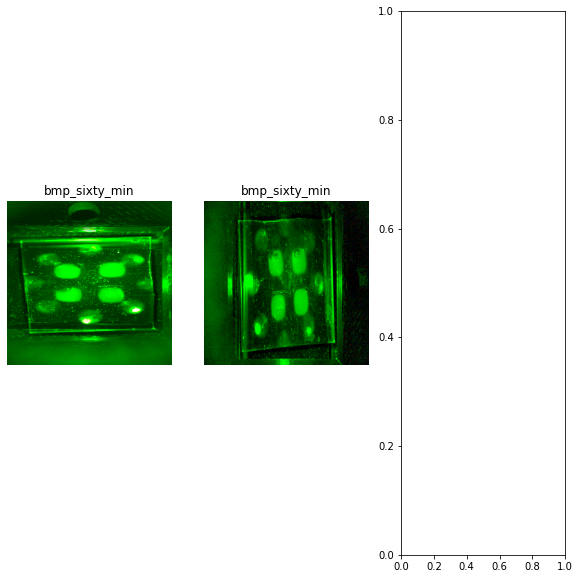

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


=====================================================================

This is initial code for image segmentation of LAMP assay images. The code is based on a [PyTorch tutorial](https://www.tensorflow.org/tutorials/images/segmentation).

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
type(train)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Mask', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

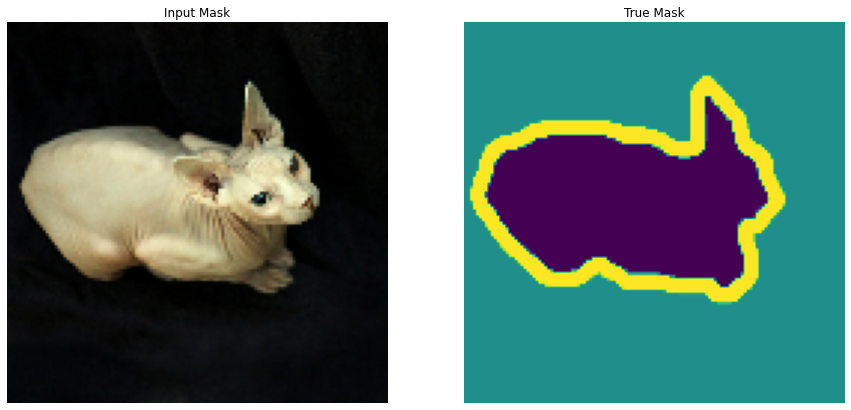

In [ ]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu', 
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'
]

layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [ 
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [ ]:
def unet_model(output)